In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
from segment_anything import sam_model_registry
from sklearn.metrics import jaccard_score, f1_score
import monai
from tqdm import tqdm
from segment_anything.utils.transforms import ResizeLongestSide
from torch.nn.functional import threshold, normalize
from torchmetrics.functional import dice, jaccard_index

In [2]:
train_img_dir = "C:/Users/anand/OneDrive - The University of Nottingham/MScProject/PyTorchDataset/train/nohairimages"
train_mask_dir = "C:/Users/anand/OneDrive - The University of Nottingham/MScProject/PyTorchDataset/train/masks"

In [3]:
class SAMDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform = None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)
        self.sam_transform = ResizeLongestSide(1024)

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace(".jpg","_segmentation.png"))

        image = np.array(Image.open(img_path).convert("RGB"))
        image = self.sam_transform.apply_image(image)
        image = torch.from_numpy(image).float().permute(2, 0, 1)    # Convert to CHW format
        

        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask = self.sam_transform.apply_image(mask)
        

        #Generating bounding box from ground truth
        y_indices, x_indices = np.where(mask > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = mask.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))

        box = self.sam_transform.apply_boxes(np.array([[x_min, y_min, x_max, y_max]]), (H, W))[0]
        box = torch.tensor(box).float()
        
        
        return image,torch.from_numpy(mask).long(),box

In [4]:
train_dataset = SAMDataset(image_dir=train_img_dir,mask_dir=train_mask_dir)

In [5]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=1, shuffle=True)

In [6]:
for img_embed, gt2D, bboxes in train_dataloader:
    # img_embed: (B, 256, 64, 64), gt2D: (B, 1, 256, 256), bboxes: (B, 4)
    print(f"{img_embed.shape=}, {gt2D.shape=}, {bboxes.shape=}")
    break

img_embed.shape=torch.Size([1, 3, 768, 1024]), gt2D.shape=torch.Size([1, 768, 1024]), bboxes.shape=torch.Size([1, 4])


In [7]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
sam = sam_model_registry['vit_b'](checkpoint="C:/Users/anand/Desktop/TST_Screening/SAM/sam_vit_b_01ec64.pth")
sam.to(device=DEVICE)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [8]:
sam.train()
optimizer = torch.optim.Adam(sam.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [9]:
num_epochs = 100
losses = []
best_loss = 1e10
input_size = (256, 256)
original_image_size = (768, 1024)
for epoch in range(num_epochs):
    epoch_loss = 0
    epoch_dice = 0
    epoch_iou = 0
    # train
    for step,(image, gt, boxes) in enumerate(tqdm(train_dataloader)):
        # Move tensors to the correct device
        image = image.to(device=DEVICE)
        gt = gt.to(device=DEVICE)
        boxes=boxes.to(device=DEVICE)
        # do not compute gradients for image encoder and prompt encoder
        with torch.no_grad():
            if boxes.dim() == 2:
                boxes = boxes.unsqueeze(1)

            # get prompt embeddings 
            sparse_embeddings, dense_embeddings = sam.prompt_encoder(
                points=None,
                boxes=boxes,
                masks=None,
            )
            img_pre = sam.preprocess(image)
            image_embeddings = sam.image_encoder(img_pre)

        # predicted masks
        mask_predictions,iou_predictions = sam.mask_decoder(
            image_embeddings=image_embeddings, 
            image_pe=sam.prompt_encoder.get_dense_pe(), 
            sparse_prompt_embeddings=sparse_embeddings, 
            dense_prompt_embeddings=dense_embeddings, 
            multimask_output=False,
            )
        
        upscaled_masks = sam.postprocess_masks(mask_predictions, input_size, original_image_size).to(device=DEVICE)
        binary_mask = normalize(threshold(upscaled_masks, 0.0, 0)).to(device=DEVICE)

        dice_score = dice(binary_mask, gt.unsqueeze(1))
        iou_score = jaccard_index(binary_mask, gt.unsqueeze(1), task='binary', average='micro')

        loss = seg_loss(upscaled_masks, gt.unsqueeze(1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_dice += dice_score.item()
        epoch_iou += iou_score.item()
    
    epoch_loss /= step
    epoch_dice /= len(train_dataloader)
    epoch_iou /= len(train_dataloader)

    losses.append(epoch_loss)
    
    print(f'EPOCH: {epoch}, Loss: {epoch_loss}')
    print(f'EPOCH: {epoch}, IOU: {epoch_iou}')
    print(f'EPOCH: {epoch}, DiceCoefficient: {epoch_dice}')
    # save the latest model checkpoint
    torch.save(sam.state_dict(), 'sam_model_latest.pth')
    # save the best model
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(sam.state_dict(), 'sam_model_best.pth')



100%|██████████| 8012/8012 [34:16<00:00,  3.90it/s]


EPOCH: 0, Loss: 0.3024004340746581
EPOCH: 0, IOU: 0.7335324449172727
EPOCH: 0, DiceCoefficient: 0.8303360680511913


100%|██████████| 8012/8012 [32:40<00:00,  4.09it/s]


EPOCH: 1, Loss: 0.20958872715988017
EPOCH: 1, IOU: 0.8092457409663321
EPOCH: 1, DiceCoefficient: 0.8922171479033393


100%|██████████| 8012/8012 [31:51<00:00,  4.19it/s]


EPOCH: 2, Loss: 0.1828825550941831
EPOCH: 2, IOU: 0.8312687317613388
EPOCH: 2, DiceCoefficient: 0.9062273570494954


100%|██████████| 8012/8012 [31:50<00:00,  4.19it/s]


EPOCH: 3, Loss: 0.16604788873110754
EPOCH: 3, IOU: 0.8459730282578388
EPOCH: 3, DiceCoefficient: 0.915289341101513


100%|██████████| 8012/8012 [31:52<00:00,  4.19it/s]


EPOCH: 4, Loss: 0.15642826111398747
EPOCH: 4, IOU: 0.8546321337788747
EPOCH: 4, DiceCoefficient: 0.9205071005414143


100%|██████████| 8012/8012 [31:52<00:00,  4.19it/s]


EPOCH: 5, Loss: 0.14934671388209173
EPOCH: 5, IOU: 0.8610069026061136
EPOCH: 5, DiceCoefficient: 0.9243096401780114


100%|██████████| 8012/8012 [31:53<00:00,  4.19it/s]


EPOCH: 6, Loss: 0.14367669173475062
EPOCH: 6, IOU: 0.8657597693904334
EPOCH: 6, DiceCoefficient: 0.9271126580622217


100%|██████████| 8012/8012 [31:54<00:00,  4.19it/s]


EPOCH: 7, Loss: 0.1396573970761397
EPOCH: 7, IOU: 0.8694017949480148
EPOCH: 7, DiceCoefficient: 0.9292437889898234


100%|██████████| 8012/8012 [31:54<00:00,  4.18it/s]


EPOCH: 8, Loss: 0.13575227593907985
EPOCH: 8, IOU: 0.8727281341627724
EPOCH: 8, DiceCoefficient: 0.9312093910229724


100%|██████████| 8012/8012 [31:54<00:00,  4.18it/s]


EPOCH: 9, Loss: 0.13291610445259455
EPOCH: 9, IOU: 0.8751430060050515
EPOCH: 9, DiceCoefficient: 0.9325786277770818


100%|██████████| 8012/8012 [31:54<00:00,  4.18it/s]


EPOCH: 10, Loss: 0.12962603769362188
EPOCH: 10, IOU: 0.8780342643253813
EPOCH: 10, DiceCoefficient: 0.9342638850881645


100%|██████████| 8012/8012 [32:56<00:00,  4.05it/s]


EPOCH: 11, Loss: 0.12713970749618864
EPOCH: 11, IOU: 0.8803003522280568
EPOCH: 11, DiceCoefficient: 0.9355833130110757


100%|██████████| 8012/8012 [31:54<00:00,  4.19it/s]


EPOCH: 12, Loss: 0.12465779339580065
EPOCH: 12, IOU: 0.8823187810462294
EPOCH: 12, DiceCoefficient: 0.936754575760824


100%|██████████| 8012/8012 [31:53<00:00,  4.19it/s]


EPOCH: 13, Loss: 0.12209292644577413
EPOCH: 13, IOU: 0.884537568478601
EPOCH: 13, DiceCoefficient: 0.9380234938098143


100%|██████████| 8012/8012 [31:50<00:00,  4.19it/s]


EPOCH: 14, Loss: 0.1204662848561128
EPOCH: 14, IOU: 0.8858591044545768
EPOCH: 14, DiceCoefficient: 0.9387827410408692


100%|██████████| 8012/8012 [31:49<00:00,  4.20it/s]


EPOCH: 15, Loss: 0.11856723905531354
EPOCH: 15, IOU: 0.8874413214635087
EPOCH: 15, DiceCoefficient: 0.9396957054332501


100%|██████████| 8012/8012 [31:50<00:00,  4.19it/s]


EPOCH: 16, Loss: 0.11656924518181686
EPOCH: 16, IOU: 0.8892383310782035
EPOCH: 16, DiceCoefficient: 0.9407236559155638


100%|██████████| 8012/8012 [31:49<00:00,  4.20it/s]


EPOCH: 17, Loss: 0.11505861860989311
EPOCH: 17, IOU: 0.8905211020590243
EPOCH: 17, DiceCoefficient: 0.9414729233226714


100%|██████████| 8012/8012 [31:50<00:00,  4.19it/s]


EPOCH: 18, Loss: 0.11359841410280383
EPOCH: 18, IOU: 0.8918944668960286
EPOCH: 18, DiceCoefficient: 0.9422444420988954


100%|██████████| 8012/8012 [31:49<00:00,  4.20it/s]


EPOCH: 19, Loss: 0.11162574079332727
EPOCH: 19, IOU: 0.8932103715684494
EPOCH: 19, DiceCoefficient: 0.9430063209880963


100%|██████████| 8012/8012 [31:50<00:00,  4.19it/s]


EPOCH: 20, Loss: 0.11043144769514601
EPOCH: 20, IOU: 0.8943960753995303
EPOCH: 20, DiceCoefficient: 0.9436792274876589


100%|██████████| 8012/8012 [31:50<00:00,  4.19it/s]


EPOCH: 21, Loss: 0.10901507483582537
EPOCH: 21, IOU: 0.8953573983636904
EPOCH: 21, DiceCoefficient: 0.9442393198959005


100%|██████████| 8012/8012 [31:50<00:00,  4.19it/s]


EPOCH: 22, Loss: 0.10749313058016556
EPOCH: 22, IOU: 0.8966166586896448
EPOCH: 22, DiceCoefficient: 0.9449527815795219


100%|██████████| 8012/8012 [31:50<00:00,  4.19it/s]


EPOCH: 23, Loss: 0.1065625802146099
EPOCH: 23, IOU: 0.8975783580104173
EPOCH: 23, DiceCoefficient: 0.9455037531528958


100%|██████████| 8012/8012 [31:50<00:00,  4.19it/s]


EPOCH: 24, Loss: 0.10543451950952899
EPOCH: 24, IOU: 0.8984951734304785
EPOCH: 24, DiceCoefficient: 0.946017224522037


100%|██████████| 8012/8012 [31:50<00:00,  4.19it/s]


EPOCH: 25, Loss: 0.10429457988719743
EPOCH: 25, IOU: 0.8993963238579061
EPOCH: 25, DiceCoefficient: 0.9465501175201124


100%|██████████| 8012/8012 [31:50<00:00,  4.19it/s]


EPOCH: 26, Loss: 0.10254195514722735
EPOCH: 26, IOU: 0.9010647492547423
EPOCH: 26, DiceCoefficient: 0.9474998819072188


100%|██████████| 8012/8012 [31:50<00:00,  4.19it/s]


EPOCH: 27, Loss: 0.10162917917612682
EPOCH: 27, IOU: 0.9016526266448925
EPOCH: 27, DiceCoefficient: 0.9478326015661671


100%|██████████| 8012/8012 [31:48<00:00,  4.20it/s]


EPOCH: 28, Loss: 0.10096156659450384
EPOCH: 28, IOU: 0.9021421831307623
EPOCH: 28, DiceCoefficient: 0.9481042693896824


100%|██████████| 8012/8012 [31:50<00:00,  4.19it/s]


EPOCH: 29, Loss: 0.09961797766068457
EPOCH: 29, IOU: 0.9032512472024633
EPOCH: 29, DiceCoefficient: 0.9487235500508407


100%|██████████| 8012/8012 [31:50<00:00,  4.19it/s]


EPOCH: 30, Loss: 0.09873286895270246
EPOCH: 30, IOU: 0.9041074805196023
EPOCH: 30, DiceCoefficient: 0.9492207311030573


100%|██████████| 8012/8012 [32:06<00:00,  4.16it/s]


EPOCH: 31, Loss: 0.09765757804204278
EPOCH: 31, IOU: 0.9050578682260756
EPOCH: 31, DiceCoefficient: 0.9497529146258259


100%|██████████| 8012/8012 [33:06<00:00,  4.03it/s]


EPOCH: 32, Loss: 0.09696183182214736
EPOCH: 32, IOU: 0.9054467691647012
EPOCH: 32, DiceCoefficient: 0.9499582399503029


100%|██████████| 8012/8012 [33:04<00:00,  4.04it/s]


EPOCH: 33, Loss: 0.0956298366169007
EPOCH: 33, IOU: 0.9066768079564622
EPOCH: 33, DiceCoefficient: 0.9506569298591485


100%|██████████| 8012/8012 [32:49<00:00,  4.07it/s]


EPOCH: 34, Loss: 0.09481238070508038
EPOCH: 34, IOU: 0.9071963233794205
EPOCH: 34, DiceCoefficient: 0.9509532950368453


100%|██████████| 8012/8012 [32:26<00:00,  4.12it/s]


EPOCH: 35, Loss: 0.0940561737269284
EPOCH: 35, IOU: 0.908017621894985
EPOCH: 35, DiceCoefficient: 0.9514064091000626


100%|██████████| 8012/8012 [32:49<00:00,  4.07it/s]


EPOCH: 36, Loss: 0.09314227272722568
EPOCH: 36, IOU: 0.9085978152331744
EPOCH: 36, DiceCoefficient: 0.951744784341118


100%|██████████| 8012/8012 [32:50<00:00,  4.07it/s]


EPOCH: 37, Loss: 0.09240335611451658
EPOCH: 37, IOU: 0.909210920557045
EPOCH: 37, DiceCoefficient: 0.9520844334194318


100%|██████████| 8012/8012 [31:55<00:00,  4.18it/s]


EPOCH: 38, Loss: 0.09166993004394408
EPOCH: 38, IOU: 0.9098560316557891
EPOCH: 38, DiceCoefficient: 0.9524503177142536


100%|██████████| 8012/8012 [31:46<00:00,  4.20it/s]


EPOCH: 39, Loss: 0.0907124953445374
EPOCH: 39, IOU: 0.910782305898514
EPOCH: 39, DiceCoefficient: 0.9529631396888556


100%|██████████| 8012/8012 [31:45<00:00,  4.21it/s]


EPOCH: 40, Loss: 0.09020697940122362
EPOCH: 40, IOU: 0.9112514096367555
EPOCH: 40, DiceCoefficient: 0.9532287713592195


100%|██████████| 8012/8012 [32:39<00:00,  4.09it/s]


EPOCH: 41, Loss: 0.08919583903588987
EPOCH: 41, IOU: 0.9119503766268536
EPOCH: 41, DiceCoefficient: 0.9536087182287687


100%|██████████| 8012/8012 [31:39<00:00,  4.22it/s]


EPOCH: 42, Loss: 0.08867223248917007
EPOCH: 42, IOU: 0.9124029686286695
EPOCH: 42, DiceCoefficient: 0.9538678305555568


100%|██████████| 8012/8012 [31:36<00:00,  4.22it/s]


EPOCH: 43, Loss: 0.08787073549004687
EPOCH: 43, IOU: 0.912943040995793
EPOCH: 43, DiceCoefficient: 0.9541659050147294


100%|██████████| 8012/8012 [32:09<00:00,  4.15it/s]


EPOCH: 44, Loss: 0.0870585952081368
EPOCH: 44, IOU: 0.9138536786086786
EPOCH: 44, DiceCoefficient: 0.9546784579500935


100%|██████████| 8012/8012 [32:08<00:00,  4.16it/s]


EPOCH: 45, Loss: 0.08680628863415102
EPOCH: 45, IOU: 0.9138425283889084
EPOCH: 45, DiceCoefficient: 0.9546631330096954


100%|██████████| 8012/8012 [31:37<00:00,  4.22it/s]


EPOCH: 46, Loss: 0.08567473026872682
EPOCH: 46, IOU: 0.9148243862616676
EPOCH: 46, DiceCoefficient: 0.9552132987895728


100%|██████████| 8012/8012 [31:56<00:00,  4.18it/s]


EPOCH: 47, Loss: 0.08517284175268108
EPOCH: 47, IOU: 0.91541074406815
EPOCH: 47, DiceCoefficient: 0.955539499343007


100%|██████████| 8012/8012 [32:39<00:00,  4.09it/s]


EPOCH: 48, Loss: 0.0847276592432556
EPOCH: 48, IOU: 0.9157834609061911
EPOCH: 48, DiceCoefficient: 0.9557388865510286


100%|██████████| 8012/8012 [33:04<00:00,  4.04it/s]


EPOCH: 49, Loss: 0.08398075993157857
EPOCH: 49, IOU: 0.9164654958623085
EPOCH: 49, DiceCoefficient: 0.9561289903585517


100%|██████████| 8012/8012 [32:43<00:00,  4.08it/s]


EPOCH: 50, Loss: 0.08342008939719545
EPOCH: 50, IOU: 0.9169433104414614
EPOCH: 50, DiceCoefficient: 0.95639277849564


100%|██████████| 8012/8012 [33:49<00:00,  3.95it/s]


EPOCH: 51, Loss: 0.08279930417634725
EPOCH: 51, IOU: 0.9173455869354014
EPOCH: 51, DiceCoefficient: 0.9566124190227187


100%|██████████| 8012/8012 [34:10<00:00,  3.91it/s]


EPOCH: 52, Loss: 0.08216811928850663
EPOCH: 52, IOU: 0.9178745283657351
EPOCH: 52, DiceCoefficient: 0.9569012986470983


100%|██████████| 8012/8012 [38:13<00:00,  3.49it/s]


EPOCH: 53, Loss: 0.08159657328178742
EPOCH: 53, IOU: 0.918432087085572
EPOCH: 53, DiceCoefficient: 0.9572149310642282


100%|██████████| 8012/8012 [38:06<00:00,  3.50it/s]


EPOCH: 54, Loss: 0.08108585287004255
EPOCH: 54, IOU: 0.9187735893014545
EPOCH: 54, DiceCoefficient: 0.9573993360064831


100%|██████████| 8012/8012 [38:00<00:00,  3.51it/s]


EPOCH: 55, Loss: 0.08060824252389401
EPOCH: 55, IOU: 0.9192934805639851
EPOCH: 55, DiceCoefficient: 0.957691330657979


100%|██████████| 8012/8012 [37:38<00:00,  3.55it/s]


EPOCH: 56, Loss: 0.08014516389024348
EPOCH: 56, IOU: 0.9196053620240001
EPOCH: 56, DiceCoefficient: 0.9578631069739937


100%|██████████| 8012/8012 [33:17<00:00,  4.01it/s]


EPOCH: 57, Loss: 0.07958560903178989
EPOCH: 57, IOU: 0.9201849070538061
EPOCH: 57, DiceCoefficient: 0.9581783302370096


100%|██████████| 8012/8012 [36:25<00:00,  3.67it/s]


EPOCH: 58, Loss: 0.07911255601454062
EPOCH: 58, IOU: 0.9206403777397577
EPOCH: 58, DiceCoefficient: 0.9584358307610615


100%|██████████| 8012/8012 [38:21<00:00,  3.48it/s]


EPOCH: 59, Loss: 0.07864234858031519
EPOCH: 59, IOU: 0.9209152041184444
EPOCH: 59, DiceCoefficient: 0.9585839814161933


100%|██████████| 8012/8012 [38:03<00:00,  3.51it/s]


EPOCH: 60, Loss: 0.07800687207431048
EPOCH: 60, IOU: 0.9214347437567194
EPOCH: 60, DiceCoefficient: 0.9588692020652774


100%|██████████| 8012/8012 [38:07<00:00,  3.50it/s]


EPOCH: 61, Loss: 0.07738184396789848
EPOCH: 61, IOU: 0.9220593805186342
EPOCH: 61, DiceCoefficient: 0.9592148531944348


100%|██████████| 8012/8012 [38:06<00:00,  3.50it/s]


EPOCH: 62, Loss: 0.07689898817573229
EPOCH: 62, IOU: 0.9225211873821657
EPOCH: 62, DiceCoefficient: 0.9594696113468705


100%|██████████| 8012/8012 [37:55<00:00,  3.52it/s]


EPOCH: 63, Loss: 0.07656074761665138
EPOCH: 63, IOU: 0.922809643472842
EPOCH: 63, DiceCoefficient: 0.9596287257377946


100%|██████████| 8012/8012 [37:52<00:00,  3.53it/s]


EPOCH: 64, Loss: 0.07621948784619482
EPOCH: 64, IOU: 0.9229724372900312
EPOCH: 64, DiceCoefficient: 0.959714022365083


100%|██████████| 8012/8012 [37:46<00:00,  3.53it/s]


EPOCH: 65, Loss: 0.07561072156520547
EPOCH: 65, IOU: 0.9235782278027466
EPOCH: 65, DiceCoefficient: 0.9600451284879098


100%|██████████| 8012/8012 [32:17<00:00,  4.14it/s]


EPOCH: 66, Loss: 0.07513408550000426
EPOCH: 66, IOU: 0.9239269146175904
EPOCH: 66, DiceCoefficient: 0.9602367511717487


100%|██████████| 8012/8012 [31:52<00:00,  4.19it/s]


EPOCH: 67, Loss: 0.07481377305572934
EPOCH: 67, IOU: 0.9243550454668563
EPOCH: 67, DiceCoefficient: 0.9604716648162155


100%|██████████| 8012/8012 [31:53<00:00,  4.19it/s]


EPOCH: 68, Loss: 0.0745239444785592
EPOCH: 68, IOU: 0.9246072958795892
EPOCH: 68, DiceCoefficient: 0.9606111445801293


100%|██████████| 8012/8012 [31:52<00:00,  4.19it/s]


EPOCH: 69, Loss: 0.07397783549337177
EPOCH: 69, IOU: 0.9250280298385629
EPOCH: 69, DiceCoefficient: 0.9608451091329634


100%|██████████| 8012/8012 [31:53<00:00,  4.19it/s]


EPOCH: 70, Loss: 0.07377768471606161
EPOCH: 70, IOU: 0.9251941438993095
EPOCH: 70, DiceCoefficient: 0.9609303498306813


100%|██████████| 8012/8012 [31:53<00:00,  4.19it/s]


EPOCH: 71, Loss: 0.07310688052239075
EPOCH: 71, IOU: 0.9257775184829058
EPOCH: 71, DiceCoefficient: 0.9612518930533381


100%|██████████| 8012/8012 [31:54<00:00,  4.19it/s]


EPOCH: 72, Loss: 0.0728665824821785
EPOCH: 72, IOU: 0.9259760428891441
EPOCH: 72, DiceCoefficient: 0.9613587031335279


100%|██████████| 8012/8012 [31:54<00:00,  4.19it/s]


EPOCH: 73, Loss: 0.07226891424046386
EPOCH: 73, IOU: 0.9266117880538411
EPOCH: 73, DiceCoefficient: 0.9617047950484071


100%|██████████| 8012/8012 [31:53<00:00,  4.19it/s]


EPOCH: 74, Loss: 0.07193333490111929
EPOCH: 74, IOU: 0.9268600012264547
EPOCH: 74, DiceCoefficient: 0.9618402901614718


100%|██████████| 8012/8012 [31:55<00:00,  4.18it/s]


EPOCH: 75, Loss: 0.07152231290858928
EPOCH: 75, IOU: 0.9271915930021541
EPOCH: 75, DiceCoefficient: 0.9620194653243467


100%|██████████| 8012/8012 [31:53<00:00,  4.19it/s]


EPOCH: 76, Loss: 0.07100506025364915
EPOCH: 76, IOU: 0.9276980111227593
EPOCH: 76, DiceCoefficient: 0.962298628104608


100%|██████████| 8012/8012 [31:53<00:00,  4.19it/s]


EPOCH: 77, Loss: 0.07066355577715072
EPOCH: 77, IOU: 0.927916722503294
EPOCH: 77, DiceCoefficient: 0.9624216431418003


100%|██████████| 8012/8012 [34:11<00:00,  3.91it/s]


EPOCH: 78, Loss: 0.07034691857854017
EPOCH: 78, IOU: 0.9282024392725168
EPOCH: 78, DiceCoefficient: 0.9625704251062376


100%|██████████| 8012/8012 [33:33<00:00,  3.98it/s]


EPOCH: 79, Loss: 0.07007344434062916
EPOCH: 79, IOU: 0.9284909495742573
EPOCH: 79, DiceCoefficient: 0.9627307989540186


100%|██████████| 8012/8012 [33:13<00:00,  4.02it/s]


EPOCH: 80, Loss: 0.06968664165308514
EPOCH: 80, IOU: 0.9289599997189065
EPOCH: 80, DiceCoefficient: 0.9629817757303573


100%|██████████| 8012/8012 [33:09<00:00,  4.03it/s]


EPOCH: 81, Loss: 0.0694582160409212
EPOCH: 81, IOU: 0.9289987507130704
EPOCH: 81, DiceCoefficient: 0.9630072939503033


100%|██████████| 8012/8012 [32:48<00:00,  4.07it/s]


EPOCH: 82, Loss: 0.06902876077535187
EPOCH: 82, IOU: 0.9294233143746228
EPOCH: 82, DiceCoefficient: 0.9632387139978137


100%|██████████| 8012/8012 [32:24<00:00,  4.12it/s]


EPOCH: 83, Loss: 0.06865488041845126
EPOCH: 83, IOU: 0.9297770568566267
EPOCH: 83, DiceCoefficient: 0.9634294481692288


100%|██████████| 8012/8012 [32:09<00:00,  4.15it/s]


EPOCH: 84, Loss: 0.06836677057516388
EPOCH: 84, IOU: 0.9300209427558358
EPOCH: 84, DiceCoefficient: 0.963555751862195


100%|██████████| 8012/8012 [31:42<00:00,  4.21it/s]


EPOCH: 85, Loss: 0.0679436671555032
EPOCH: 85, IOU: 0.9305031448453888
EPOCH: 85, DiceCoefficient: 0.963823654311809


100%|██████████| 8012/8012 [31:43<00:00,  4.21it/s]


EPOCH: 86, Loss: 0.06772314876338846
EPOCH: 86, IOU: 0.9306138802024048
EPOCH: 86, DiceCoefficient: 0.9638810397102068


100%|██████████| 8012/8012 [31:44<00:00,  4.21it/s]


EPOCH: 87, Loss: 0.06739042099205922
EPOCH: 87, IOU: 0.9308367674269202
EPOCH: 87, DiceCoefficient: 0.9640059265727945


100%|██████████| 8012/8012 [31:43<00:00,  4.21it/s]


EPOCH: 88, Loss: 0.06706009025465418
EPOCH: 88, IOU: 0.9312011457596548
EPOCH: 88, DiceCoefficient: 0.9642045398875587


100%|██████████| 8012/8012 [31:43<00:00,  4.21it/s]


EPOCH: 89, Loss: 0.06682058224263165
EPOCH: 89, IOU: 0.9315445404081302
EPOCH: 89, DiceCoefficient: 0.9643900292445229


100%|██████████| 8012/8012 [32:09<00:00,  4.15it/s]


EPOCH: 90, Loss: 0.0664361121122129
EPOCH: 90, IOU: 0.9319077403513837
EPOCH: 90, DiceCoefficient: 0.9645864347175426


100%|██████████| 8012/8012 [32:24<00:00,  4.12it/s]


EPOCH: 91, Loss: 0.06608514649246204
EPOCH: 91, IOU: 0.9321400535088804
EPOCH: 91, DiceCoefficient: 0.9647136299730954


100%|██████████| 8012/8012 [31:53<00:00,  4.19it/s]


EPOCH: 92, Loss: 0.06592735891681359
EPOCH: 92, IOU: 0.9322519062149245
EPOCH: 92, DiceCoefficient: 0.9647742279071065


100%|██████████| 8012/8012 [31:55<00:00,  4.18it/s]


EPOCH: 93, Loss: 0.06558178287620406
EPOCH: 93, IOU: 0.9325965135932505
EPOCH: 93, DiceCoefficient: 0.9649571712113474


100%|██████████| 8012/8012 [31:43<00:00,  4.21it/s]


EPOCH: 94, Loss: 0.06543661984148516
EPOCH: 94, IOU: 0.9326471406864156
EPOCH: 94, DiceCoefficient: 0.9649863394048889


100%|██████████| 8012/8012 [31:37<00:00,  4.22it/s]


EPOCH: 95, Loss: 0.06490908095824939
EPOCH: 95, IOU: 0.9332394292368867
EPOCH: 95, DiceCoefficient: 0.9653097484270097


100%|██████████| 8012/8012 [31:42<00:00,  4.21it/s]


EPOCH: 96, Loss: 0.06480470259737602
EPOCH: 96, IOU: 0.933351003849917
EPOCH: 96, DiceCoefficient: 0.9653674381275029


100%|██████████| 8012/8012 [31:46<00:00,  4.20it/s]


EPOCH: 97, Loss: 0.06463946506060518
EPOCH: 97, IOU: 0.9334612961521878
EPOCH: 97, DiceCoefficient: 0.9654271942091417


100%|██████████| 8012/8012 [32:19<00:00,  4.13it/s]


EPOCH: 98, Loss: 0.06429796003355354
EPOCH: 98, IOU: 0.9337318207746854
EPOCH: 98, DiceCoefficient: 0.965571459388352


100%|██████████| 8012/8012 [33:03<00:00,  4.04it/s]


EPOCH: 99, Loss: 0.0638917784306825
EPOCH: 99, IOU: 0.9341171838778349
EPOCH: 99, DiceCoefficient: 0.9657847803426396


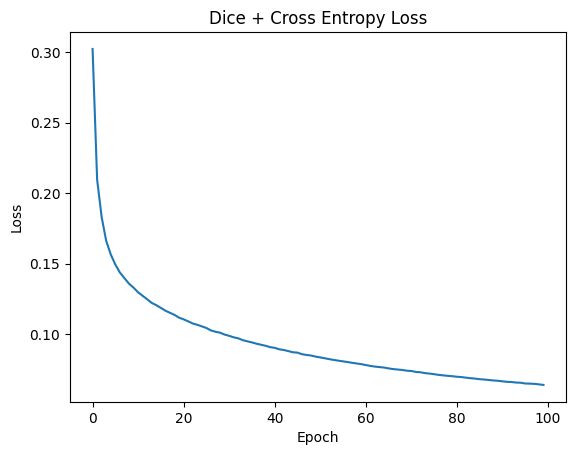

In [10]:
# plot loss
plt.plot(losses)
plt.title('Dice + Cross Entropy Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show() # comment this line if you are running on a server

Inference


In [41]:
#%% compare the segmentation results between the original SAM model and the fine-tuned model
# load the original SAM model
from skimage import io
from segment_anything import SamPredictor

ori_sam_model = sam_model_registry['vit_b'](checkpoint="C:/Users/anand/Desktop/TST_Screening/SAM/sam_vit_b_01ec64.pth").to(device=DEVICE)
ori_sam_predictor = SamPredictor(ori_sam_model)

ts_img_path = "C:/Users/anand/OneDrive - The University of Nottingham/MScProject/PyTorchDataset/test/images"
ts_gt_path = "C:/Users/anand/OneDrive - The University of Nottingham/MScProject/PyTorchDataset/test/masks"
test_names = sorted(os.listdir(ts_img_path))

# random select a test case
img_idx = np.random.randint(len(test_names))
image_data = io.imread(os.path.join(ts_img_path, test_names[img_idx]))
if image_data.shape[-1]>3 and len(image_data.shape)==3:
    image_data = image_data[:,:,:3]
if len(image_data.shape)==2:
    image_data = np.repeat(image_data[:,:,None], 3, axis=-1)
# read ground truth (gt should have the same name as the image) and simulate a bounding box
def get_bbox_from_mask(mask):
    '''Returns a bounding box from a mask'''
    y_indices, x_indices = np.where(mask > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = mask.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))

    return np.array([x_min, y_min, x_max, y_max])

gt_data = io.imread(os.path.join(ts_gt_path, test_names[img_idx]).replace(".jpg","_segmentation.png"))
bbox_raw = get_bbox_from_mask(gt_data)


# preprocess: cut-off and max-min normalization
lower_bound, upper_bound = np.percentile(image_data, 0.5), np.percentile(image_data, 99.5)
image_data_pre = np.clip(image_data, lower_bound, upper_bound)
image_data_pre = (image_data_pre - np.min(image_data_pre))/(np.max(image_data_pre)-np.min(image_data_pre))*255.0
image_data_pre[image_data==0] = 0
image_data_pre = np.uint8(image_data_pre)
H, W, _ = image_data_pre.shape
print(H,W)

# predict the segmentation mask using the original SAM model
ori_sam_predictor.set_image(image_data_pre)
ori_sam_seg, _, _ = ori_sam_predictor.predict(point_coords=None, box=bbox_raw, multimask_output=False)
print(ori_sam_seg.shape)

450 600
(1, 450, 600)


In [42]:
# predict the segmentation mask using the fine-tuned model
# resize image to 3*1024*1024
sam_transform = ResizeLongestSide(1024)
resize_image = sam_transform.apply_image(image_data_pre)
print("ResizeLongside:", resize_image.shape)
image = torch.from_numpy(resize_image).float().permute(2,0,1).to(device=DEVICE)
input_image = sam.preprocess(image[None,:,:,:])
print("Image Preprocess:" ,input_image.shape)

with torch.no_grad():
    # pre-compute the image embedding
    img_pre = sam.preprocess(input_image)
    ts_img_embedding = sam.image_encoder(input_image)
    print("Image Embedding:", image_embeddings.shape)
    # convert box to 1024x1024 grid
    bbox = sam_transform.apply_boxes(bbox_raw, (H, W))
    print(f'{bbox_raw=} -> {bbox=}')
    box_torch = torch.as_tensor(bbox, dtype=torch.float, device=DEVICE)
    if len(bbox_raw.shape) == 2:
        box_torch = bbox_raw[:, None, :] # (B, 4) -> (B, 1, 4)
    
    sparse_embeddings, dense_embeddings = sam.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    medsam_seg_prob, _ = sam.mask_decoder(
        image_embeddings=ts_img_embedding.to(device=DEVICE), # (B, 256, 64, 64)
        image_pe=sam.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
        multimask_output=False,
        )
    
    upscaled_masks = sam.postprocess_masks(medsam_seg_prob, input_size, (450,600)).to(device=DEVICE)
    binary_mask = normalize(threshold(upscaled_masks, 0.0, 0)).to(device=DEVICE)

    medsam_seg_prob = torch.sigmoid(upscaled_masks)
    print(medsam_seg_prob)
    # convert soft mask to hard mask
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)
    print(medsam_seg.shape)

ResizeLongside: (768, 1024, 3)
Image Preprocess: torch.Size([1, 3, 1024, 1024])
Image Embedding: torch.Size([1, 256, 64, 64])
bbox_raw=array([125,  48, 457, 403], dtype=int64) -> bbox=array([[213.33333333,  81.92      , 779.94666667, 687.78666667]])
tensor([[[[4.0047e-13, 4.0047e-13, 4.0047e-13,  ..., 1.7171e-10,
           1.7282e-10, 1.7319e-10],
          [4.0047e-13, 4.0047e-13, 4.0047e-13,  ..., 1.7171e-10,
           1.7282e-10, 1.7319e-10],
          [4.0047e-13, 4.0047e-13, 4.0047e-13,  ..., 1.7171e-10,
           1.7282e-10, 1.7319e-10],
          ...,
          [4.5208e-12, 4.5208e-12, 4.5208e-12,  ..., 2.8850e-10,
           4.3775e-10, 5.0193e-10],
          [4.1559e-12, 4.1559e-12, 4.1559e-12,  ..., 4.3910e-10,
           6.4142e-10, 7.2635e-10],
          [3.9443e-12, 3.9443e-12, 3.9443e-12,  ..., 5.6999e-10,
           8.1320e-10, 9.1377e-10]]]], device='cuda:0')
(450, 600)


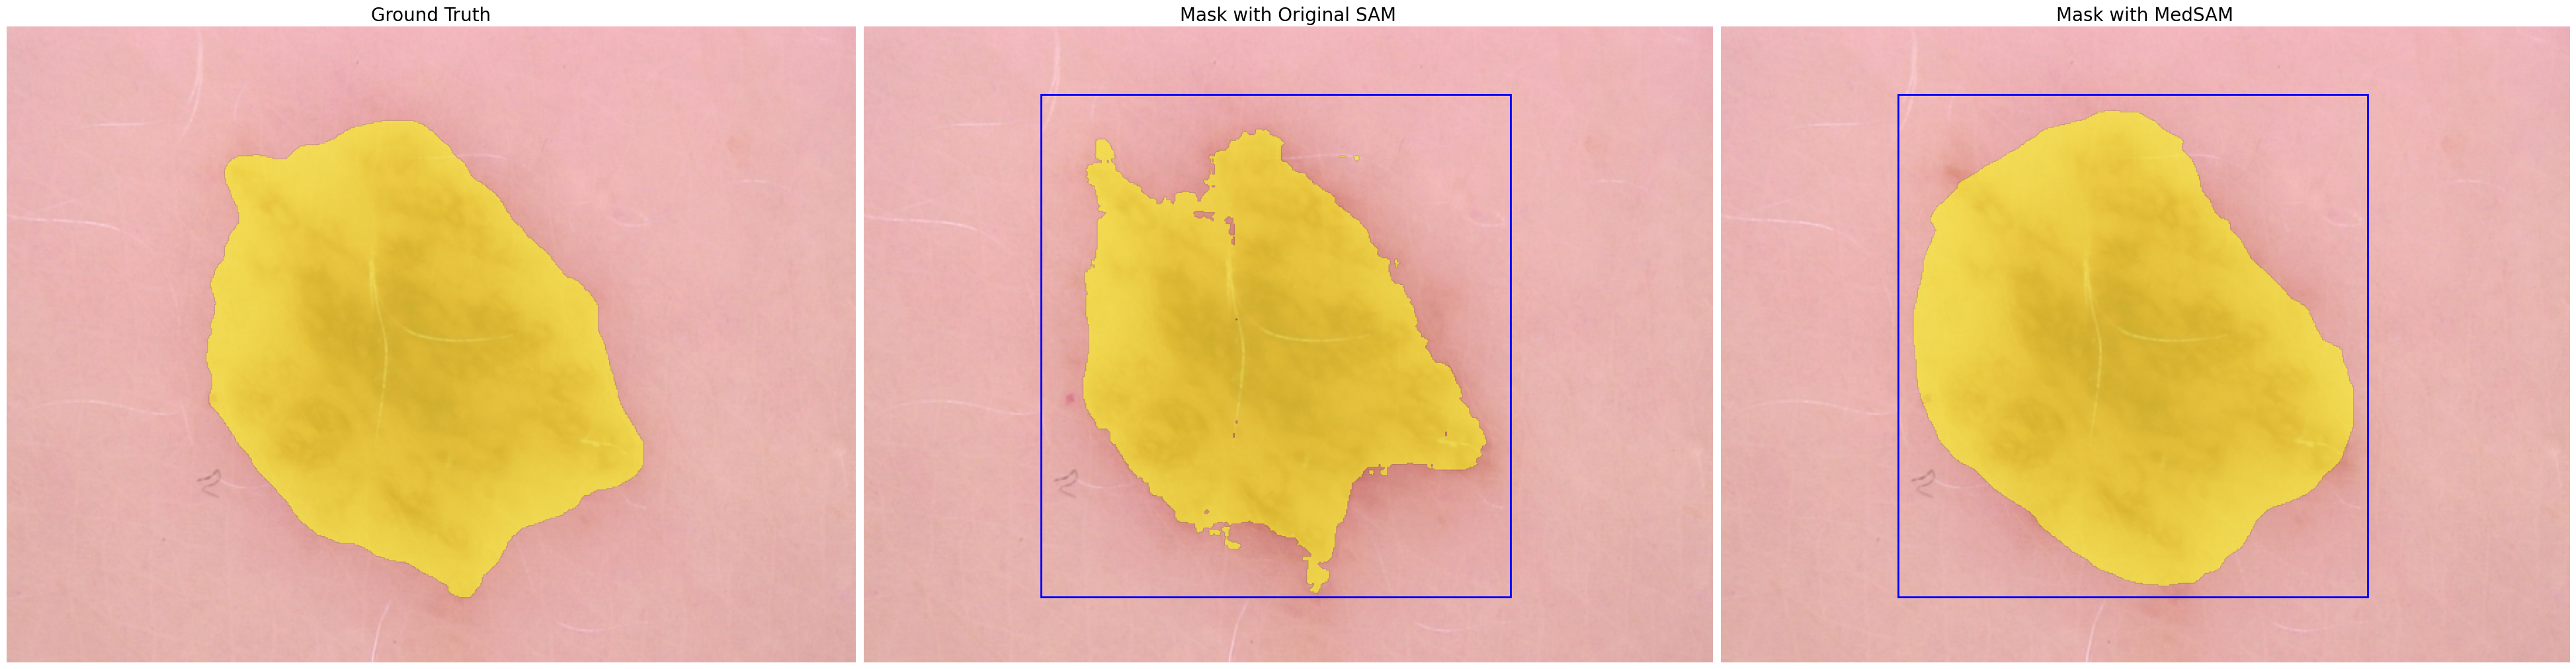

In [43]:
#%% visualize the segmentation results of the middle slice
# visualization functions
# source: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
# change color to avoid red and green
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
   
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=2))    

_, axs = plt.subplots(1, 3, figsize=(50, 50))

# Ground Truth
axs[0].imshow(image_data)
show_mask(gt_data>0, axs[0])
axs[0].set_title('Ground Truth', fontsize=20)
axs[0].axis('off')

# Original SAM
axs[1].imshow(image_data)
show_mask(ori_sam_seg, axs[1])
show_box(bbox_raw, axs[1])
#axs[1].text(0.5, 0.5, 'SAM DSC: {:.4f}'.format(ori_sam_dsc), fontsize=30, horizontalalignment='left', verticalalignment='top', color='yellow')
axs[1].set_title('Mask with Original SAM', fontsize=20)
axs[1].axis('off')

# MedSAM
axs[2].imshow(image_data)
show_mask(medsam_seg, axs[2])
show_box(bbox_raw, axs[2])
#axs[2].text(0.5, 0.5, 'MedSAM DSC: {:.4f}'.format(medsam_dsc), fontsize=30, horizontalalignment='left', verticalalignment='top', color='yellow')
axs[2].set_title('Mask with MedSAM', fontsize=20)
axs[2].axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0)
plt.show()  

# save plot
# plt.savefig(join(model_save_path, test_npzs[npz_idx].split('.npz')[0] + str(img_id).zfill(3) + '.png'), bbox_inches='tight', dpi=300)
plt.close()

In [44]:
from SurfaceDice import compute_dice_coefficient

ori_sam_dsc = compute_dice_coefficient(gt_data>0, ori_sam_seg>0)
medsam_dsc = compute_dice_coefficient(gt_data>0, medsam_seg>0)
print('Original SAM DSC: {:.4f}'.format(ori_sam_dsc), 'MedSAM DSC: {:.4f}'.format(medsam_dsc))

Original SAM DSC: 0.8751 MedSAM DSC: 0.9549
